<a href="https://colab.research.google.com/github/Nohyeong/PFAS_ML/blob/main/AFFF_ML_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
!pip install bayesian-optimization
!pip install shap
!pip install catboost

Mounted at /gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 18.5 MB/s eta 0:00:00


In [ ]:
from xgboost.sklearn import XGBRegressor
import os
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
import time
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from tensorflow.keras.callbacks import EarlyStopping
import os
import warnings
warnings.filterwarnings('ignore')

random_state = 1

# def data_prep(data):
#   # data = data.dropna(axis=0)
#   # data['d_p-d_pi'] = data['pres'] - 8.314*298*data['Total conc']*0.001
#   # data = data[data['d_p-d_pi']>0]
#   # data['IEP'] = data['IEP'].str.lstrip('graph')
#   data['IEP-pH'] = data['IEP'].astype(float) - data['pH']
#   data.index = range(len(data))
#   data['Charge_product'] = data['IEP-pH'] * data['Atomic_charge']
#   return data

def make_plot_matplotlib(row, column, var_list):
  fig, axs = plt.subplots(row, column, figsize = [23, 10])
  k = 0
  for i in range(row):
    for j in range(column):
      sns.distplot(ax=axs[i, j], x=df[var_list[k]], label="Skewness : %.2f"%(df[var_list[k]].skew()))
      axs[i, j].legend(loc="best")
      axs[i, j].set_title(var_list[k])
      axs[i, j].set_xlim(left=df[var_list[k]].min()*0.9, right=df[var_list[k]].max()*1)
      axs[i, j].set_ylim(bottom=0)
      k += 1
      if k == len(var_list):
        break
  fig.subplots_adjust(hspace=0.3, wspace=0.3)
  return fig.show()

def prep(df):
  df['Init_conc'] = np.log10(df['Init_conc'])
  # df['MWCO'] = df['MWCO']**5
  # df['Pres'] = np.log10(df['Pres'])

  return df

def postp(df):
  df['Init_conc'] = 10**(df['Init_conc'])
  # df['MWCO'] = np.power(df['MWCO'], 1/5)
  # df['Pres'] = 10**(df['Pres'])

  return df

def CV_group(data):
  data['ref_PFAS'] = data['ref_ID'].map(str) + data['PFAS']

  ref_PFAS = data['ref_PFAS']
  tt_ion = pd.DataFrame(ref_PFAS.value_counts(ascending=False))
  tt_ion_index = tt_ion.index

  one = pd.DataFrame()
  two = pd.DataFrame()
  three = pd.DataFrame()
  four = pd.DataFrame()
  five = pd.DataFrame()

  for i in range(len(tt_ion_index)):
    a = [len(one), len(two), len(three), len(four), len(five)]
    if a.index(min(a))==0:
      one = pd.concat([one, pd.DataFrame(data[data['ref_PFAS']==tt_ion_index[i]])])
    elif a.index(min(a))==1:
      two = pd.concat([two, pd.DataFrame(data[data['ref_PFAS']==tt_ion_index[i]])])
    elif a.index(min(a))==2:
      three = pd.concat([three, pd.DataFrame(data[data['ref_PFAS']==tt_ion_index[i]])])
    elif a.index(min(a))==3:
      four = pd.concat([four, pd.DataFrame(data[data['ref_PFAS']==tt_ion_index[i]])])
    elif a.index(min(a))==4:
      five = pd.concat([five, pd.DataFrame(data[data['ref_PFAS']==tt_ion_index[i]])])

  print('one len: ', len(one))
  print('two len: ', len(two))
  print('three len: ', len(three))
  print('four len: ', len(four))
  print('five len: ', len(five))

  return one, two, three, four, five

def createFolder(directory):
    try:
      if not os.path.exists(directory):
        os.makedirs(directory)
    except OSError:
      print('Error: Creating directory. ' + directory)

class ML_model():
   def __init__(self, train, test, one, two, three, four, five, features, model_type):

      self.X_train = pd.DataFrame(train)
      self.X_test = pd.DataFrame(test)
      self.y_train = train['Removal_rate']
      self.y_test = test['Removal_rate']
      self.X_train_1 = pd.concat([two,three,four,five], join='outer')
      self.X_test_1 = one
      self.X_train_2 = pd.concat([one,three,four,five], join='outer')
      self.X_test_2 = two
      self.X_train_3 = pd.concat([one,two,four,five], join='outer')
      self.X_test_3 = three
      self.X_train_4 = pd.concat([one,two,three,five], join='outer')
      self.X_test_4 = four
      self.X_train_5 = pd.concat([one,two,three,four], join='outer')
      self.X_test_5 = five
      self.features = features
      self.model_type = model_type
      self.y_train_1 = self.X_train_1['Removal_rate']
      self.y_train_2 = self.X_train_2['Removal_rate']
      self.y_train_3 = self.X_train_3['Removal_rate']
      self.y_train_4 = self.X_train_4['Removal_rate']
      self.y_train_5 = self.X_train_5['Removal_rate']
      self.y_test_1 = self.X_test_1['Removal_rate']
      self.y_test_2 = self.X_test_2['Removal_rate']
      self.y_test_3 = self.X_test_3['Removal_rate']
      self.y_test_4 = self.X_test_4['Removal_rate']
      self.y_test_5 = self.X_test_5['Removal_rate']
      self.X_train_1 = self.X_train_1[self.features]
      self.X_train_2 = self.X_train_2[self.features]
      self.X_train_3 = self.X_train_3[self.features]
      self.X_train_4 = self.X_train_4[self.features]
      self.X_train_5 = self.X_train_5[self.features]
      self.X_test_1 = self.X_test_1[self.features]
      self.X_test_2 = self.X_test_2[self.features]
      self.X_test_3 = self.X_test_3[self.features]
      self.X_test_4 = self.X_test_4[self.features]
      self.X_test_5 = self.X_test_5[self.features]

   def rem_name(self, org_data):
     data_name = org_data.loc[:,['ID','Membrane','PFAS']]
     return data_name

   def CV_train(self, regressor, X_train, y_train, X_test, y_test):
     cv_result = regressor.fit(X_train, y_train)
     cv_y_pred = cv_result.predict(X_test)
     return np.sqrt(mean_squared_error(y_test, cv_y_pred))

   def data_prep_for_model(self, regressor):
     rmse_1 = self.CV_train(regressor, self.X_train_1, self.y_train_1, self.X_test_1, self.y_test_1)
     rmse_2 = self.CV_train(regressor, self.X_train_2, self.y_train_2, self.X_test_2, self.y_test_2)
     rmse_3 = self.CV_train(regressor, self.X_train_3, self.y_train_3, self.X_test_3, self.y_test_3)
     rmse_4 = self.CV_train(regressor, self.X_train_4, self.y_train_4, self.X_test_4, self.y_test_4)
     rmse_5 = self.CV_train(regressor, self.X_train_5, self.y_train_5, self.X_test_5, self.y_test_5)

     rmse = [rmse_1, rmse_2, rmse_3, rmse_4, rmse_5]
     rmse_mean = np.mean(rmse)
     return -1*rmse_mean

   def xgb_evaluate(self, colsample_bytree, gamma, learning_rate, max_depth, min_child_weight,
                  reg_alpha, reg_lambda, subsample, n_estimators):
     regressor = XGBRegressor(objective ='reg:squarederror',
                              booster='gbtree',
                              eval_metric='rmse',
                              colsample_bytree=colsample_bytree,
                              gamma=gamma,
                              learning_rate=learning_rate,
                              max_depth=int(max_depth),
                              min_child_weight=int(min_child_weight),
                              reg_alpha=reg_alpha,
                              reg_lambda=reg_lambda,
                              subsample=subsample,
                              n_estimators=int(n_estimators))

     return self.data_prep_for_model(regressor)

   def rfr_optimization(self, max_depth, min_samples_split, n_estimators):
     regressor = RandomForestRegressor(bootstrap=True,
                                       max_depth=int(max_depth),
                                       max_features='auto',
                                       min_samples_split=int(min_samples_split),
                                       n_estimators=int(n_estimators))

     return self.data_prep_for_model(regressor)

   def lgb_optimization(self, n_estimators, learning_rate, max_depth, lambda_l1,
                        lambda_l2, bagging_fraction, feature_fraction):

     regressor = lgb.LGBMRegressor(n_estimators=int(n_estimators),
                     learning_rate=learning_rate,
                     max_depth=int(max_depth),
                     lambda_l1=lambda_l1,
                     lambda_l2=lambda_l2,
                     bagging_fraction=bagging_fraction,
                     feature_fraction=feature_fraction)

     return self.data_prep_for_model(regressor)

   def cat_optimization(self, learning_rate, max_depth, l2_leaf_reg, random_strength):

     regressor = cat.CatBoostRegressor(logging_level='Silent',
                                       learning_rate=learning_rate,
                                       max_depth=int(max_depth),
                                       l2_leaf_reg=int(l2_leaf_reg),
                                       random_strength=random_strength)

     return self.data_prep_for_model(regressor)

   def param(self):

     if self.model_type == 'xgb':
       pbounds = {'colsample_bytree': (0.5, 0.9),
                  'gamma':(0,1),
                  'learning_rate':(0.0001, 0.1),
                  'max_depth':(3, 10),
                  'min_child_weight':(0.0001, 5),
                  'reg_alpha': (0, 1),
                  'reg_lambda': (0, 1),
                  'subsample':(0.5, 0.9),
                  'n_estimators':(1, 1000)}

       bo = BayesianOptimization(self.xgb_evaluate, pbounds=pbounds, verbose=2, random_state=random_state)

     elif self.model_type == 'RF':
       pbounds = {'n_estimators': (10, 1000),
                  'max_depth': (3, 10),
                  'min_samples_split': (2, 10)}
       bo = BayesianOptimization(self.rfr_optimization, pbounds=pbounds, verbose=2, random_state=random_state)

     elif self.model_type == 'lgb':
       pbounds = {'n_estimators': (10, 1000),
                  'learning_rate':(0.0001, 0.1),
                  'max_depth':(3, 10),
                  'lambda_l1':(0, 100),
                  'lambda_l2':(0, 100),
                  'bagging_fraction':(0.1,1),
                  'feature_fraction':(0.1,1)}
       bo = BayesianOptimization(self.lgb_optimization, pbounds=pbounds, verbose=2, random_state=random_state)

     elif self.model_type == 'cat':
       pbounds = {'learning_rate':(0.001, 0.01),
                  'max_depth':(3, 10),
                  'l2_leaf_reg':(2, 10),
                  'random_strength':(0,10)}
       bo = BayesianOptimization(self.cat_optimization, pbounds=pbounds, verbose=2, random_state=random_state)


     elif self.model_type == 'nn':
       pbounds = {'learning_rate':(0.0001, 0.1),
                  'num_dense_layers':(3, 5),
                  'num_neuron':(4, 64)}
       bo = BayesianOptimization(self.nn_optimization, pbounds=pbounds, verbose=2, random_state=random_state)


     print('='*20)
     print()

     acq_func = UtilityFunction(kind='ei')
     bo.maximize(init_points=3, n_iter=20, acquisition_function=acq_func)

     F_params = pd.DataFrame(bo.max['params'], index=range(1))
     F_params.to_csv(directory + '/' + date + '_' + file_title + '_parameters.csv')

     return bo.max['params']

   def final_model(self, X_train, y_train):
     params = self.param()
     if self.model_type == 'xgb':
       final_model = xgb.XGBRegressor(colsample_bytree=params['colsample_bytree'], gamma=params['gamma'],
                                 learning_rate=params['learning_rate'], max_depth=int(params['max_depth']),
                                 min_child_weight=params['min_child_weight'],
                                 n_estimators=round(params['n_estimators']),
                                 early_stop_rounds=10, reg_alpha=params['reg_alpha'],
                                 reg_lambda=params['reg_lambda'], subsample=params['subsample'],
                                 silent=1, random_state = random_state, nthread = -1)
       final_model.fit(X_train, y_train)
     elif self.model_type == 'RF':
       final_model = RandomForestRegressor(n_estimators=round(params['n_estimators']),
                                        max_depth=int(params['max_depth']),
                                        min_samples_split=int(params['min_samples_split']),
                                        random_state=random_state)
       final_model.fit(X_train, y_train)

     elif self.model_type == 'lgb':
           final_model = lgb.LGBMRegressor(n_estimators=round(params['n_estimators']),
                                           learning_rate=params['learning_rate'],
                                           max_depth=int(params['max_depth']),
                                           lambda_l1=params['lambda_l1'],
                                           lambda_l2=params['lambda_l2'],
                                           bagging_fraction=params['bagging_fraction'],
                                           feature_fraction=params['feature_fraction'],
                                           random_state=random_state)
           final_model.fit(X_train, y_train)

     elif self.model_type == 'cat':
           final_model = cat.CatBoostRegressor(logging_level='Silent',
                                               learning_rate=params['learning_rate'],
                                               max_depth=int(params['max_depth']),
                                               l2_leaf_reg=params['l2_leaf_reg'],
                                               random_strength=params['random_strength'],
                                               random_state=random_state)
           final_model.fit(X_train, y_train)

     elif self.model_type == 'nn':

           early_stopping = EarlyStopping()

           final_model = Sequential()

           for i in range(int(params['num_dense_layers'])):
             final_model.add(tf.keras.layers.Dense(params['num_neuron'], activation='relu'))

           final_model.add(tf.keras.layers.Dense(1))

           final_model.compile(loss=tf.keras.losses.mae,
                         optimizer = 'rmsprop',
                         metrics = ['mae'])
           final_model.fit(X_train, y_train, epochs=500,
                           callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)],
                           verbose=True,
                           )

     return final_model

   def result(self, model):

     X_train_name = self.rem_name(self.X_train)
     X_test_name = self.rem_name(self.X_test)

     y_train =  self.X_train['Removal_rate']
     y_test =  self.X_test['Removal_rate']

     y_pred = model.predict(self.X_test[self.features])
     y_train_pred = model.predict(self.X_train[self.features])

     train_err = np.sqrt(mean_squared_error(y_train, y_train_pred))
     val_err  = np.sqrt(mean_squared_error(y_test, y_pred))
     mae = mean_absolute_error(y_test, y_pred)

     MAE = pd.DataFrame({"Train_RMSE": str(train_err), "Test RMSE": str(val_err), "MAE": str(mae)}, index = range(1))
     MAE.to_excel(directory + '/' + date + '_' + file_title + '_MAE.xlsx', sheet_name='MAE')

     print("\tTraining RMSE\t\t" + str(train_err))
     print("\tTest RMSE\t\t" + str(val_err))
     print("\tMean absolute error\t" + str(mae))

     y_pred = pd.DataFrame(y_pred)
     y_pred.columns = ['pred']
     y_test = pd.DataFrame(y_test)
     y_test.columns = ['y_test']
     y_train_pred = pd.DataFrame(y_train_pred)
     y_train_pred.columns=['pred']

     total = pd.concat([X_train_name, self.X_train[self.features], y_train], axis=1)
     y_train_pred.index = total.index

     total_train = pd.concat([total, y_train_pred],axis=1)

     df_1_test = pd.concat([self.X_test[self.features], y_test], axis=1)
     y_test.index = df_1_test.index

     y_pred.index = df_1_test.index
     y_pred

     total_test = pd.concat([X_test_name, df_1_test, y_pred], axis=1)

     total_train['error'] = total_train['Removal_rate'] - total_train['pred']
     total_test['error'] = total_test['y_test'] - total_test['pred']

     total_train.to_csv(directory + '/' + date + '_' + file_title + '_total_train.csv')
     total_test.to_csv(directory + '/' + date + '_' + file_title + '_total_test.csv')
     total_test.to_csv(directory_test + '/' + date + '_' + file_title + '_total_test.csv')

     train_error = total_train.loc[:,['Removal_rate','pred','error']]
     test_error = total_test.loc[:,['y_test','pred','error']]

     f1 = plt.figure()
     ax = sns.scatterplot(x="y_test", y="pred", data=test_error)
     ax.set(xlim=(0,110), ylim=(0,105), title='Test pred-real Removal_rate')
     plt.savefig(directory + '/' + date + '_' + file_title + '_test_pred_real_removal_rate.png', dpi=300)
     return self

def preprocess_data(df):
    # df['mb_charge'] = df['pH'] - df['IEP']
    df['Init_conc'] = df['Init_conc']/df['Mw']
    return df

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# features = ['MWCO', 'CA', 'Size', 'logKoc', 'pKa', 'Init_conc', 'Pres', 'mb_charge']
# corr_features = features + ['Removal_rate']
# corrmat = df[corr_features].corr()
# plt.subplots(figsize=(12,9))
# sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)
# plt.savefig(title+'_corr_mat_' +date+'.png', dpi=300)

# #print(' first: \t\t {} \n second: \t\t {} \n third: \t\t {}'.format(first_sum, second_sum, third_sum))

one len:  95
two len:  95
three len:  95
four len:  95
five len:  94

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -8.864    | 0.6668    | 0.7203    | 0.0001114 | 5.116     | 0.7339    | 93.25     | 0.1863    | 0.3456    | 0.6587    |
| 2         | -7.136    | 0.7155    | 0.4192    | 0.06855   | 4.431     | 4.391     | 28.36     | 0.6705    | 0.4173    | 0.7235    |
| 3         | -6.925    | 0.5562    | 0.1981    | 0.08009   | 9.778     | 1.567     | 692.6     | 0.8764    | 0.8946    | 0.534     |
| 4         | -6.736    | 0.5847    | 0.6173    | 0.04716   | 9.997     | 1.236     | 692.5     | 0.6059    | 0.7316    | 0.7191    |
| 5         | -8.628    | 0.9       | 1.0       | 0.0001    | 10.0      | 0.0001    | 691.0     | 0.0       | 0.0       | 0.9 

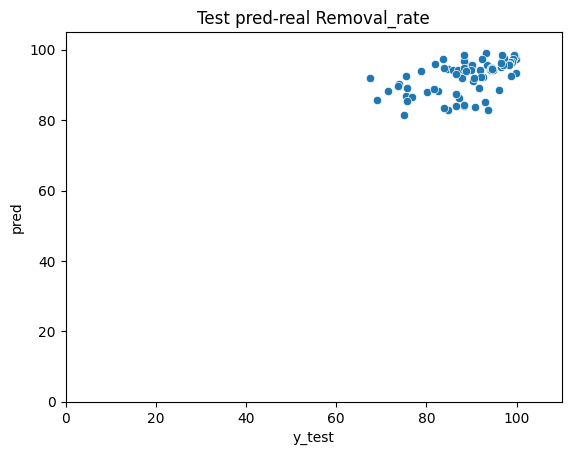

In [ ]:
# prediction of multiple ref_PFAS
import pandas as pd
from datetime import datetime
import pytz

now_utc = datetime.now(pytz.utc)
est_timezone = pytz.timezone('US/Eastern')
now_est = now_utc.astimezone(est_timezone)
date = now_est.strftime('%Y%m%d_%H:%M:%S')

model_type = 'xgb'
title = 'AFFF_XGB'
SHAP_title = 'SHAP_' + title
file_title = '_'

df = pd.read_excel('/gdrive/My Drive/AFFF_ML/AFFF Data_20230222.xlsx', sheet_name='data')

df = df[df['MWCO']<400]
df = df[df['Membrane']!='NE70']

# df['IEP'] = df['IEP'].str.lstrip('graph').astype(float)
df['group'] = df['ref_ID'].astype(str) + '_' + df['PFAS']

df = preprocess_data(df)
df = df.dropna(subset=['IEP'])
df.index = range(len(df))

features = ['MWCO', 'CA', 'Size', 'logKoc', 'Init_conc', 'Pres', 'Total_IS', 'mb_charge']

train = df[df['ref_ID']!='1']
test = df[df['ref_ID']=='1']

############################################################################################################

df['ref_PFAS'] = df['ref_ID'].map(str) + df['PFAS']
ref_PFAS = df['ref_PFAS']
b = pd.DataFrame(ref_PFAS.value_counts().sort_values(ascending=False))
ref_PFAS = b.index

df.dropna(axis=0, inplace=True)

directory = '/gdrive/My Drive/AFFF_ML/' + date + '/' + title + '/' + file_title + '/'
directory_test = '/gdrive/My Drive/AFFF_ML/' + date + '/' + title + '/' + 'test'
createFolder(directory_test)
createFolder(directory)

df['ref_ID'] = df['ref_ID'].map(str)

features = ['MWCO', 'CA', 'Size', 'logKow', 'Init_conc', 'Pres', 'Total_IS', 'mb_charge']

one, two, three, four, five = CV_group(train)

ml_model = ML_model(train, test, one, two ,three, four, five, features, model_type)

final_model = ml_model.final_model(train[features], train['Removal_rate'])
result = ml_model.result(final_model)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from sklearn.metrics import r2_score

train['pred'] = final_model.predict(train[features])
test['pred'] = final_model.predict(test[features])

train_pred_mae = mean_absolute_error(train['pred'], train['Removal_rate'])
train_pred_rmse = mean_squared_error(train['pred'], train['Removal_rate'], squared = False)

train['mark'] = 'train'
test['mark'] = 'test'
total_data = pd.concat([train, test])

X_title = 'Real removal (%)'
Y_title = 'Pred removal (%)'

title_font_size = 43 # 33
tickfont_size = 35 # 23
ticklen = 5 # 5
tickwidth = 2 # 2
title_standoff = 20

plot_width = 600 # 700
plot_height = 500 # 500

pred_mae = mean_absolute_error(test['pred'], test['Removal_rate'])
pred_rmse = mean_squared_error(test['pred'], test['Removal_rate'], squared = False)

print(F"MAE: {np.round(pred_mae,2)}, RMSE: {np.round(pred_rmse,2)}")
print(F"Train MAE: {np.round(train_pred_mae,2)}, Train RMSE: {np.round(train_pred_rmse,2)}")

x_data = test['Removal_rate'].values.reshape(-1, 1)
y_data = test['pred'].values.reshape(-1, 1)

# Create a Linear Regression model that forces the y intercept to 0
model = LinearRegression(fit_intercept=False)

# Fit the model to the data
model.fit(x_data, y_data)

# Get the model predictions
pred = model.predict(x_data)

fig = px.scatter(total_data, x='Removal_rate', y='pred', color = 'mark',
                 width=plot_width, height=plot_height, range_x=[-10, 120], range_y=[-10, 120]
                 #,color_continuous_scale='bluered'
                 )

fig.update_layout(
    xaxis = dict(
        dtick=25,
        #tickangle = 90,
        title_text = X_title,
        title_font = {"size": title_font_size},
        tickfont = dict(family='Arial', color='black', size=tickfont_size),
        title_standoff = title_standoff,
        color='black',
        ticks="inside",
        ticklen=ticklen,
        tickwidth=tickwidth,
        title_font_family="Arial"),
    yaxis = dict(
        dtick = 25,
        title_text = Y_title,
        title_font = {"size": title_font_size},
        tickfont = dict(family='Arial', color='black', size=tickfont_size),
        title_standoff = title_standoff,
        color='black',
        ticks="inside",
        ticklen=ticklen,
        tickwidth=tickwidth,
        title_font_family="Arial"))

fig.update_layout(plot_bgcolor='rgb(256,256,256)', showlegend=False)

fig.update_xaxes(showline=True, linewidth=4, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=4, linecolor='black', mirror=True)

random_x = [0, 100]
random_y0 = [0, 100]

fig.add_trace(go.Scatter(x=random_x, y=random_y0, line=dict(color='red', width=2), marker=dict(size=1)))

#marker_color = 'cornflowerblue'
fig.update_traces(marker=dict(size=10, opacity=0.65, line=dict(width=0.7)), selector=dict(mode='markers'))

fig.show()

MAE: 5.62, RMSE: 7.72
Train MAE: 0.65, Train RMSE: 0.91


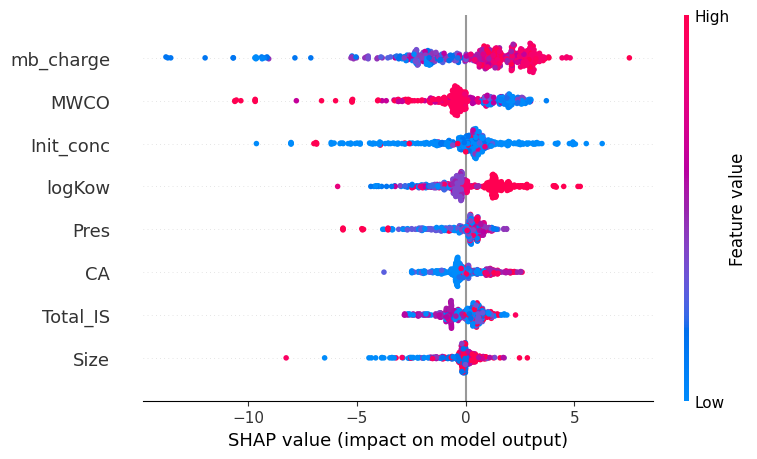

In [ ]:
import shap
%matplotlib inline

X_train = train.copy()
X_train_name = X_train.loc[:,['ID','Membrane','PFAS']]

X_train = X_train[features]

f1 = plt.figure()
explainer = shap.TreeExplainer(final_model) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, show=False)
plt.savefig(directory + '/' + date + '_' + SHAP_title + "_SHAP.pdf", format='pdf', dpi=1000)

shap_values = pd.DataFrame(shap_values)
shap_features = [feature+'-SHAP' for feature in features]
shap_values.columns = shap_features.copy()

X_train_name.index = range(len(X_train_name))
X_train.index = range(len(X_train))
shap_values.index = range(len(shap_values))
total = pd.concat([X_train_name, X_train, shap_values], axis=1)
shap_values.index = X_train.index
total.to_csv(directory + '/' + date + '_' + SHAP_title + '_shap_values.csv')

In [ ]:
shap_values = total.copy()
shap_sum = np.abs(shap_values[shap_features]).mean(axis=0)
importance_df = pd.DataFrame([shap_values[features].columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df.index = range(len(shap_sum))
importance_df.sort_values(by='shap_importance',ascending=True, inplace=True)
importance_df.shap_importance = importance_df.shap_importance/importance_df['shap_importance'][0]*100

import plotly.express as px

X_title = 'SHAP importance'
Y_title = ''

title_font_size = 43 # 33
tickfont_size = 35 # 23
ticklen = 5 # 5
tickwidth = 4 # 2
title_standoff = 20


plot_width = 700 # 1000
plot_height = 500 # 700

fig = px.bar(importance_df, x="shap_importance", y="column_name", orientation='h',
             width=plot_width, height=plot_height)

for data in fig.data:
    data["width"] = 0.7 #Change this value for bar widths


fig.update_layout(
    xaxis = dict(
        #dtick = 25,
        #tickangle = 90,
        title_text = X_title,
        title_font = {"size": title_font_size},
        tickfont = dict(family='Arial', color='black', size=tickfont_size),
        title_standoff = title_standoff,
        color='black',
        ticks="inside",
        ticklen=ticklen,
        tickwidth=tickwidth,
        title_font_family="Arial"),
    yaxis = dict(
        #dtick = 15,
        title_text = Y_title,
        title_font = {"size": title_font_size},
        tickfont = dict(family='Arial', color='black', size=tickfont_size-15),
        title_standoff = title_standoff,
        color='black',
        ticks="inside",
        ticklen=ticklen,
        tickwidth=tickwidth,
        title_font_family="Arial"))

fig.update_layout(plot_bgcolor='rgb(256,256,256)')

fig.update_xaxes(showline=True, linewidth=4, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=4, linecolor='black', mirror=True)

fig.show()

In [ ]:
# SHAP dependent plot

X = 'Init_conc'
unit = ''
Y = X + '-SHAP'

import plotly.express as px


title_font_size = 43 # 33
tickfont_size = 40 # 23
ticklen = 5 # 5
tickwidth = 3.5 # 2
title_standoff = 20

plot_width = 570 # 700, 577
plot_height = 530 # 500 ,530

X_title = X + unit
Y_title = 'SHAP value'

fig = px.scatter(total, x=X, y=Y,
                 #  range_x = [0.323, 0.387],  range_y=[-10, 40],
                 color_discrete_sequence=['#636EFA', '#00CC96', '#EF553B'],
                #  color_discrete_sequence=['#636EFA', '#00CC96'],
                 width=plot_width, height=plot_height)

fig.update_layout(
    xaxis = dict(
        # dtick=2,
        tickangle = 0,
        title_text = X_title,
        title_font = {"size": title_font_size},
        tickfont = dict(family='Arial', color='black', size=tickfont_size),
        title_standoff = title_standoff,
        color='black',
        ticks="inside",
        ticklen=ticklen,
        tickwidth=tickwidth,
        title_font_family="Arial"),
    yaxis = dict(
        dtick = 3,
        title_text = Y_title,
        title_font = {"size": title_font_size},
        tickfont = dict(family='Arial', color='black', size=tickfont_size),
        title_standoff = title_standoff,
        color='black',
        ticks="inside",
        ticklen=ticklen,
        tickwidth=tickwidth,
        title_font_family="Arial"))

fig.update_layout(plot_bgcolor='rgb(256,256,256)')

fig.update_xaxes(showline=True, linewidth=4.5, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=4.5, linecolor='black', mirror=True)

#marker_color = 'cornflowerblue'
fig.update_traces(marker=dict(size=12, opacity=0.65, line=dict(width=0.7)), selector=dict(mode='markers'), showlegend=False)

fig.show()